In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.config import load_config_nb

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import yaml
from nocturne.envs.base_env import BaseEnv

# Load environment settings
env_config = load_config_nb("env_config")

env_config.data_path = "../data_full/train/"

### Compute element-wise min and max across the dataset | **Ego state**

Goals:
- Check if the distributions make sense
- Obtain max values for standardization

In [21]:
env_config.subscriber.use_observations = False
env_config.normalize_state = False

# Initialize an environment
env = BaseEnv(config=env_config)

avg_init_dist_to_goal = []
N = 10_000
for i in range(N):
    ego_states = env.reset()
    for agent_id in ego_states.keys():
        #print(f"init_dist_to_goal: {ego_states[agent_id][3]:.2f}")

        avg_init_dist_to_goal.append(ego_states[agent_id][3])

In [25]:
np.mean(avg_init_dist_to_goal)

45.92252323399768

In [26]:
len(avg_init_dist_to_goal)

67357

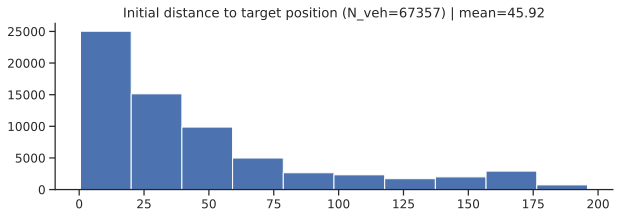

In [27]:
plt.title(f"Initial distance to target position (N_veh={len(avg_init_dist_to_goal)}) | mean={np.mean(avg_init_dist_to_goal):.2f}")
plt.hist(avg_init_dist_to_goal)
sns.despine()

In [36]:
(np.array(avg_init_dist_to_goal) < 1.0).sum() / len(avg_init_dist_to_goal) * 100

2.8623602595127458

In [37]:
(np.array(avg_init_dist_to_goal) < 1.5).sum() / len(avg_init_dist_to_goal) * 100

4.624612141277075

In [38]:
(np.array(avg_init_dist_to_goal) < 2.0).sum() / len(avg_init_dist_to_goal) * 100

6.6214350401591515

In [39]:
(np.array(avg_init_dist_to_goal) < 4.0).sum() / len(avg_init_dist_to_goal) * 100

11.107976899208694

In [57]:
env_config['num_files'] = 10_000
env_config['subscriber']['use_ego_state'] = True
env_config['subscriber']['use_observations'] = False
env_config['sample_file_method'] = 'no_replacement'

TOTAL_STEPS = 50_000

ego_state_values = []
invalid_scenes = []

env = BaseEnv(config=env_config)

# Reset
obs_dict = env.reset()

# Get info
agent_ids = [agent_id for agent_id in obs_dict.keys()]

for step in range(TOTAL_STEPS):

    for veh_obj in env.controlled_vehicles:
        veh_obj.expert_control = False
    
    # Sample actions
    action_dict = {
        agent_id: env.action_space.sample() 
        for agent_id in agent_ids
    }
    
    # Step in env
    obs_dict, rew_dict, done_dict, info_dict = env.step({})

    idx = 0
    for agent_id, obs in obs_dict.items():
        ego_state_values.append(obs)

        if obs[6] > 77:
            veh_obj = env.controlled_vehicles[idx]
            print(f'veh {veh_obj.id} speed: {veh_obj.speed:.2f} | target_speed: {veh_obj.target_speed:.2f} | DIFF (target_speed): {obs[6]:.2f}')
            #print(f'actual_diff: {veh_obj.target_speed - veh_obj.speed:.2f}')
            
            invalid_scenes.append(env.file)
            print(f'scene: {env.file}')

        idx += 1
        
    # Reset if all agents are done
    if done_dict["__all__"]:
        obs_dict = env.reset()  

# Close environment
env.close()

ego_state_values = np.array(ego_state_values)

In [62]:
feat_names = ['veh_length', 'veh_width', 'speed', 'target_dist', 'target_azimuth', 'target_heading', 'target_speed', 'curr_accel', 'curr_steering', 'curr_head_angle']

# Create a DataFrame
df = pd.DataFrame(ego_state_values, columns=feat_names)

In [63]:
df.shape

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [64]:
df.describe()

,veh_length,veh_width,speed,target_dist,target_azimuth,target_heading,target_speed,curr_accel,curr_steering,curr_head_angle
count,270062.00,270062.00,270062.00,270062.00,270062.00,270062.00,270062.00,270062.00,270062.00,270062.00
mean,4.90,2.16,8.05,32.31,-0.03,0.02,0.74,0.00,0.00,0.00
std,0.85,0.19,7.49,34.49,1.30,0.52,4.18,0.00,0.00,0.00
min,2.97,1.53,0.00,0.00,-3.14,-3.14,-29.64,0.00,0.00,0.00
25%,4.52,2.03,1.85,8.39,-0.05,-0.02,-1.35,0.00,0.00,0.00
50%,4.70,2.10,5.62,20.62,-0.00,-0.00,0.73,0.00,0.00,0.00
75%,5.13,2.28,13.07,43.53,0.04,0.02,2.82,0.00,0.00,0.00
max,15.36,3.36,38.54,295.06,3.14,3.13,39.15,0.00,0.00,0.00


In [67]:
df.max().values

veh_length         15.36
veh_width           3.36
speed              38.54
target_dist       295.06
target_azimuth      3.14
target_heading      3.13
target_speed       39.15
curr_accel          0.00
curr_steering       0.00
curr_head_angle     0.00
dtype: float64

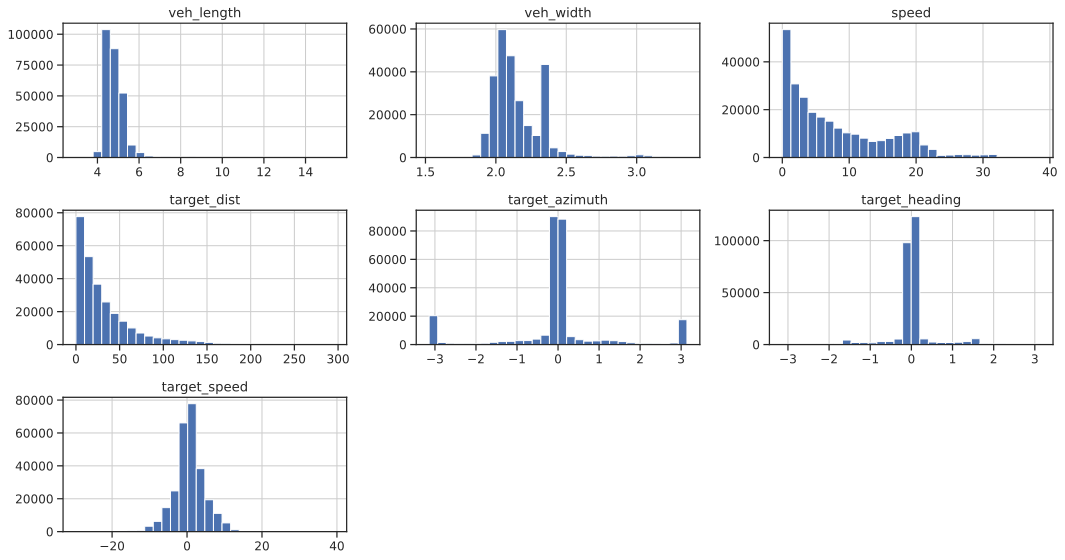

In [65]:
df.hist(column=feat_names[:7], sharex=False, sharey=False, figsize=(15, 8), bins=30);
plt.tight_layout()

### Compute element-wise min and max across the dataset | **Visible state**

In [68]:
env_config['num_files'] = 10_000
env_config['subscriber']['use_ego_state'] = False
env_config['subscriber']['use_observations'] = True
env_config['sample_file_method'] = 'random'
TOTAL_STEPS = 1000

In [73]:
vis_state_values = []

env = BaseEnv(config=env_config)

# Reset
obs_dict = env.reset()

# Get info
agent_ids = [agent_id for agent_id in obs_dict.keys()]

for step in range(TOTAL_STEPS):

    for veh_obj in env.controlled_vehicles:
        veh_obj.expert_control = False
    
    # Sample actions
    action_dict = {
        agent_id: env.action_space.sample() 
        for agent_id in agent_ids
    }
    
    # Step in env
    obs_dict, rew_dict, done_dict, info_dict = env.step({})

    for idx, obs in obs_dict.items():
        vis_state_values.append(obs)
        
    # Reset if all agents are done
    if done_dict["__all__"]:
        obs_dict = env.reset()  

# Close environment
env.close()

vis_state_values = np.array(vis_state_values)

In [74]:
vis_state_values.shape

(4500, 6720)

In [76]:
vis_state_values.max()

82.44021606445312

In [77]:
vis_state_values

array([[ 1.        , 12.34047413, -0.07785842, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  7.75049448, -0.54768687, ...,  1.        ,
        51.80866241,  0.32514498],
       [ 1.        ,  9.35578156,  0.99823713, ...,  1.        ,
        41.27997589,  0.42190021],
       ...,
       [ 1.        , 16.98324203,  0.26835012, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  8.27435493, -1.56097007, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , 16.01068878,  0.28510928, ...,  0.        ,
         0.        ,  0.        ]])

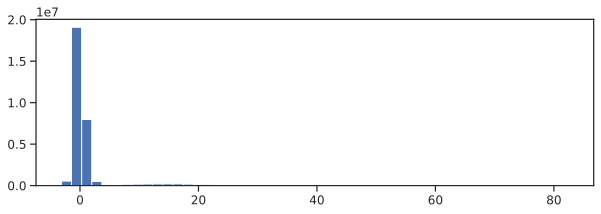

In [78]:
plt.hist(vis_state_values.flatten(), bins=50);

In [ ]:
vis_state_values.flatten()

In [ ]:
[]